In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# TODO: Import data from .npy files, check if num_classes = 10 is correct

#  U-net

In [6]:
import os
from torch.utils.data import DataLoader, Dataset
import torchvision as tv
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pathlib
import glob2

In [7]:
data_path = 'carseg_data/clean_data/'

full_dir = [ pathlib.Path(p).absolute() for p in glob2.glob(data_path + '*') ]
print('Number of files:', len(full_dir))

Number of files: 3521


In [8]:
all_npy_files = [np.load(f) for f in full_dir]
all_classes = [list(set(a[3].flatten())) for a in all_npy_files]

In [9]:
# Read test ids
import os
with open('./carseg_data/test_ids.txt','r',encoding='utf-8') as f:
    test_ids = f.read().splitlines()
with open('./carseg_data/new_train_ids.txt','r',encoding='utf-8') as f:
    train_ids = f.read().splitlines()

test_ids_short = []
for filename in test_ids:
    filename = filename.rsplit('.', maxsplit=1)[0]
    test_ids_short.append(filename)

train_ids_short = []
for filename in train_ids:
    filename = filename.rsplit('.', maxsplit=1)[0]
    train_ids_short.append(filename)
# print(train_ids_short)
all_ids_short = []
for filename in full_dir:
    filename = os.path.splitext(os.path.basename(filename))[0]
    all_ids_short.append(filename)

In [10]:
# Only extract test files using the test ids
test_files = np.array(all_npy_files)[np.isin(all_ids_short, test_ids_short)]

# train_ids_short = np.setdiff1d(all_ids_short, test_ids_short)

train_files = np.array(all_npy_files)[np.isin(all_ids_short, train_ids_short)]

In [11]:
np.random.shuffle(train_files)
print(train_files.shape)

(249, 4, 256, 256)


In [12]:
train_split_percent = 0.99
train_labels = train_files[:int(train_split_percent*len(train_files)), 3]
train_set = train_files[:int(train_split_percent*len(train_files)), :-1]

val_labels = train_files[int(train_split_percent*len(train_files)):, 3]
val_set = train_files[int(train_split_percent*len(train_files)):, :-1]

test_labels = test_files[:, 3]
test_set = test_files[:, :-1]
print(train_labels.shape)
print(train_set.shape)
print(test_files.shape)
print(test_set.shape)
print(test_labels.shape)

print(val_set.shape)

(246, 256, 256)
(246, 3, 256, 256)
(30, 4, 256, 256)
(30, 3, 256, 256)
(30, 256, 256)
(3, 3, 256, 256)


In [13]:
classes = list(set(train_labels.flatten()))
num_classes = len(classes)
print(classes)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]


[0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0]
Shape img: (256, 256, 3)


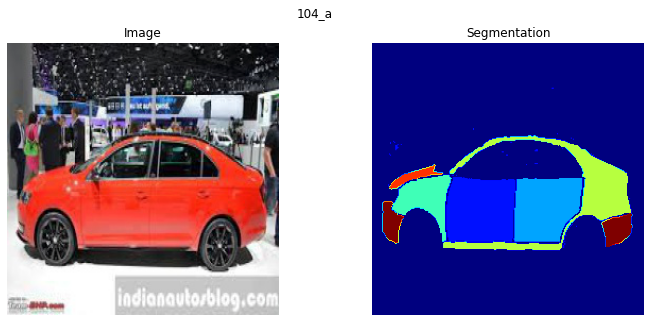

In [14]:
import matplotlib.pyplot as plt
index = np.random.randint(len(train_files))
img_ex = train_files[index]

labels_in_img = list(set(img_ex[3].flatten()))
print(labels_in_img)

anImage = (np.transpose(img_ex[:3], (1, 2, 0))*255).astype(int)
print('Shape img:', anImage.shape)

plt.figure(figsize=(12,5), facecolor='white')
plt.suptitle(full_dir[index].stem)

plt.subplot(1,2,1)
plt.title('Image')
plt.imshow(anImage)
plt.axis(False)

plt.subplot(1,2,2)
plt.title('Segmentation')
plt.imshow(img_ex[3]*255, cmap='jet')
plt.axis(False)

plt.show()

In [15]:
# img size -> (512,256)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [16]:
from torchvision import transforms, datasets

# parameters
lr = 1e-3
batch_size = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# U-Net model
class UNet(nn.Module):
    
    def __init__(self, num_classes, num_channels):
        super(UNet, self).__init__()
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=self.num_channels, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=self.num_classes, kernel_size=3, stride=1, padding=1)
        self.output2 = torch.nn.Softmax2d()
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        X = X.to(device)
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        output_out = self.output2(output_out)
        return output_out

In [18]:
# U-Net++ L3 model
import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv2(nn.Module):
    '''(conv-BN-ReLU)X2 :   in_ch  , out_ch , out_ch    '''

    def __init__(self, in_ch, out_ch):
        super(double_conv2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=2, dilation=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),  # True means cover the origin input
            nn.Conv2d(out_ch, out_ch, 3, padding=3, dilation=3),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.Upsample(scale_factor=2)
        self.conv = double_conv2(in_ch, out_ch)

    def forward(self, x1, x2):  # x1--up , x2 ---down
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (
            diffY // 2, diffY - diffY // 2,
            diffX // 2, diffX - diffX // 2,))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class up3(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up3, self).__init__()
        self.up = nn.Upsample(scale_factor=2)
        self.conv = double_conv2(in_ch, out_ch)

    def forward(self, x1, x2, x3):
        # print(x1.shape)
        x1 = self.up(x1)
        x = torch.cat([x3, x2, x1], dim=1)
        x = self.conv(x)
        return x


class up4(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up4, self).__init__()
        self.up = nn.Upsample(scale_factor=2)
        self.conv = double_conv2(in_ch, out_ch)

    def forward(self, x1, x2, x3, x4):  # x1--up , x2 ---down
        # print(x1.shape)
        x1 = self.up(x1)
        x = torch.cat([x4, x3, x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.upsample = nn.Upsample(scale_factor=4)
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        x = torch.sigmoid(x)
        return x


class double_conv(nn.Module):
    '''(conv-BN-ReLU)X2 :   in_ch  , in_ch , out_ch    '''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, padding=2, dilation=2),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),  # True means cover the origin input
            nn.Conv2d(in_ch, out_ch, 3, padding=3, dilation=3),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class double_conv_in(nn.Module):
    '''(conv-BN-ReLU)X2 :   in_ch  , in_ch , out_ch    '''

    def __init__(self, in_ch, out_ch):
        super(double_conv_in, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 5, padding=2),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),  # True means cover the origin input
            nn.Conv2d(in_ch, out_ch, 3, padding=1, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv_in(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


cc = 256  # you can change it to 8, then the model can be more faster ,reaching 35 fps on cpu when testing
# 32 is better than 8 and 16, try 64 maybe


class Unet_2D(nn.Module):
    def __init__(self, n_channels, n_classes, dropout=0):
        super(Unet_2D, self).__init__()
        self.inconv = inconv(n_channels, cc)
        self.dr = dropout
        self.dropout = torch.nn.Dropout2d(self.dr)
        self.down1 = down(cc, 2 * cc)
        self.down2 = down(2 * cc, 4 * cc)
        self.down3 = down(4 * cc, 8 * cc)
        self.up1 = up(12 * cc, 4 * cc)
        self.up20 = up(6 * cc, 2 * cc)
        self.up2 = up3(8 * cc, 2 * cc)
        self.up30 = up(3 * cc, cc)
        self.up31 = up3(4 * cc, cc)
        self.up3 = up4(5 * cc, cc)
        self.outconv = outconv(cc, n_classes)

    def forward(self, x):
        x1 = self.inconv(x)
        x1 = self.dropout(x1)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x21 = self.up20(x3, x2)
        x21 = self.dropout(x21)
        x = self.up2(x, x21, x2)
        x = self.dropout(x)
        x11 = self.up30(x2, x1)
        x11 = self.dropout(x11)
        x12 = self.up31(x21, x11, x1)
        x12 = self.dropout(x12)
        x = self.up3(x, x12, x11, x1)
        x = self.dropout(x)
        #output 0 1 2
        y2 = self.outconv(x)
        y0 = self.outconv(x11)
        y1 = self.outconv(x12)
        return y0, y1, y2

In [19]:
class car_dataset(Dataset):
    def __init__(self,data,labels, transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        sample = self.data[idx]
        # print(sample.shape)
        sample = torch.Tensor(sample)
        if self.transforms is not None:
            # sample = sample.transpose(0, 1).transpose(1, 2)
            # print(transforms is None)
            sample = self.transforms(sample)

        label_class = self.labels[idx]  # label_model.predict(label.reshape(-1,3)).reshape(256,256)
        label_class = torch.Tensor(label_class).long()
        return sample,label_class

In [20]:
def one_hot(label, n_classes, requires_grad=True):
    """Return One Hot Label"""
    divce = label.device
    one_hot_label = torch.eye(
        n_classes, device=device, requires_grad=requires_grad)[label]
    one_hot_label = one_hot_label.transpose(1, 3).transpose(2, 3)

    return one_hot_label

In [21]:
class dice_loss(torch.nn.Module):
    def __init__(self, num_classes, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        self.n_classes = num_classes

    def __call__(self, pred, target):
        """This definition generalize to real valued pred and target vector.
        This should be differentiable.
        pred: tensor with first dimension as batch
        target: tensor with first dimension as batch
        """
        self.smooth = 1.
        loss = 0.
        target = torch.nn.functional.one_hot(target, self.n_classes).transpose(2, 3).transpose(1, 2)
        # print(target)
        # print(pred.shape)
        for c in range(self.n_classes):
            iflat = pred[:, c].reshape(-1)
            tflat = target[:, c].reshape(-1)
            intersection = (iflat * tflat).sum()

            # w = class_weights[c]  # The classes are weighted equally
            loss += (1 - ((2. * intersection + self.smooth) /
                            (iflat.sum() + tflat.sum() + self.smooth)))
        return loss

In [22]:
class f1_score(torch.nn.Module):
    def __init__(self, num_classes, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        self.num_classes = num_classes

    def __call__(self, pred, target):
        """This definition generalize to real valued pred and target vector.
        This should be differentiable.
        pred: tensor with first dimension as batch
        target: tensor with first dimension as batch
        """
        self.smooth = 1.
        score = 0
        target = torch.nn.functional.one_hot(target, self.num_classes).transpose(2, 3).transpose(1, 2)
        pred1 = torch.argmax(pred, dim=1)
        pred1 = torch.nn.functional.one_hot(pred1, self.num_classes).transpose(2, 3).transpose(1, 2)
        for c in range(self.num_classes):
            iflat = pred1[:, c].reshape(-1)
            tflat = target[:, c].reshape(-1)
            intersection = (iflat * tflat).sum()
            # print(iflat.shape)
            s = ((2. * intersection + self.smooth) / (iflat.sum() + tflat.sum() + self.smooth))
            # print(s)
            score += s

        return score/self.num_classes

In [23]:
class BoundaryLoss(nn.Module):
    """Boundary Loss proposed in:
    Alexey Bokhovkin et al., Boundary Loss for Remote Sensing Imagery Semantic Segmentation
    https://arxiv.org/abs/1905.07852
    """

    def __init__(self, theta0=3, theta=5):
        super().__init__()

        self.theta0 = theta0
        self.theta = theta

    def forward(self, pred, gt):
        """
        Input:
            - pred: the output from model (before softmax)
                    shape (N, C, H, W)
            - gt: ground truth map
                    shape (N, H, w)
        Return:
            - boundary loss, averaged over mini-bathc
        """

        n, c, _, _ = pred.shape

        # softmax so that predicted map can be distributed in [0, 1]
        pred = torch.softmax(pred, dim=1)

        # one-hot vector of ground truth
        one_hot_gt = one_hot(gt, c)

        # boundary map
        gt_b = F.max_pool2d(
            1 - one_hot_gt, kernel_size=self.theta0, stride=1, padding=(self.theta0 - 1) // 2)
        gt_b -= 1 - one_hot_gt

        pred_b = F.max_pool2d(
            1 - pred, kernel_size=self.theta0, stride=1, padding=(self.theta0 - 1) // 2)
        pred_b -= 1 - pred

        # extended boundary map
        gt_b_ext = F.max_pool2d(
            gt_b, kernel_size=self.theta, stride=1, padding=(self.theta - 1) // 2)

        pred_b_ext = F.max_pool2d(
            pred_b, kernel_size=self.theta, stride=1, padding=(self.theta - 1) // 2)

        # reshape
        gt_b = gt_b.view(n, c, -1)
        pred_b = pred_b.view(n, c, -1)
        gt_b_ext = gt_b_ext.view(n, c, -1)
        pred_b_ext = pred_b_ext.view(n, c, -1)

        # Precision, Recall
        P = torch.sum(pred_b * gt_b_ext, dim=2) / (torch.sum(pred_b, dim=2) + 1e-7)
        R = torch.sum(pred_b_ext * gt_b, dim=2) / (torch.sum(gt_b, dim=2) + 1e-7)

        # Boundary F1 Score
        BF1 = 2 * P * R / (P + R + 1e-7)

        # summing BF1 Score for each class and average over mini-batch
        loss = torch.mean(1 - BF1)

        return loss

In [24]:
# trainTransform  = tv.transforms.Compose([tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                                          tv.transforms.ToPILImage(),
#                                          tv.transforms.Grayscale(num_output_channels=1),
#                                          tv.transforms.ToTensor()]); num_channels = 1
# trainTransform = tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)); num_channels = 3
trainTransform = tv.transforms.Grayscale(num_output_channels=1); num_channels = 1
# trainTransform = None; num_channels = 3
train_dataset = car_dataset(train_set, train_labels, transforms=trainTransform)
train_data_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

val_dataset = car_dataset(val_set, val_labels, transforms=trainTransform)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

model = UNet(num_classes = num_classes, num_channels=num_channels); model_type = 'UNet'
# model = Unet_2D(n_channels=num_channels, n_classes=num_classes, dropout=0); model_type = 'UNet++'

if torch.cuda.is_available():
    model.cuda()

criterion_CE = nn.CrossEntropyLoss()
criterion_boundary = BoundaryLoss()
criterion_dice = dice_loss(num_classes=num_classes)

dice_score = f1_score(num_classes=num_classes)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)

In [25]:
SMOOTH = 1e-6

def iou(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W

    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return iou.mean() # thresholded.mean() #thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [26]:
step_losses = []
epoch_losses = []
epoch_iou_scores = []
epoch_dice_scores = []
val_step_losses = []
val_epoch_losses = []
val_epoch_iou_scores = []
val_epoch_dice_scores = []

epochs = 600
step = 0
validation_every_steps = 30
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    val_epoch_loss = 0
    epoch_iou_score = 0
    val_epoch_iou_score = 0
    epoch_dice_score = 0
    val_epoch_dice_score = 0
    val_steps = 0

    for X,Y in tqdm(train_data_loader, total=len(train_data_loader), leave=False):
        X,Y = X.to(device),Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss_dice = 0
        loss_boundary = 0
        loss_CE = 0
        iou_score = 0
        dice_score_train = 0
        if model_type == 'UNet++':
            for i in range(len(Y_pred)):
                loss_dice += criterion_dice(Y_pred[i], Y)
                loss_CE += criterion_CE(Y_pred[i], Y)
                # loss_boundary += criterion_boundary(Y_pred[i], Y)
            loss_dice = loss_dice/len(Y_pred)
            loss_CE = loss_CE/len(Y_pred)
            loss_boundary = loss_boundary/len(Y_pred)
            Y_pred_iou = torch.argmax(Y_pred[2], dim=1)
            iou_score = iou(Y_pred_iou, Y)
            dice_score_train = dice_score(Y_pred[2], Y)
        elif model_type == 'UNet':
            loss_dice = criterion_dice(Y_pred, Y)
            loss_CE = criterion_CE(Y_pred, Y)
            # loss_boundary = criterion_boundary(Y_pred, Y)
            Y_pred_iou = torch.argmax(Y_pred, dim=1)
            iou_score = iou(Y_pred_iou, Y)
            dice_score_train = dice_score(Y_pred, Y)
        loss = loss_dice + loss_CE + loss_boundary
        loss.backward()
        optimizer.step()
        step += 1
        epoch_loss+=loss.item()
        epoch_iou_score += iou_score.item()
        epoch_dice_score += dice_score_train.item()
        step_losses.append(loss.item())
        if step % validation_every_steps == 0:
            # Compute accuracies on validation set.
            valid_loss_batches = []
            with torch.no_grad():
                model.eval()
                for X_val, Y_val in val_data_loader:
                    X_val, Y_val = X_val.to(device), Y_val.to(device)
                    Y_pred_val = model(X_val)
                    loss = 0
                    loss_dice = 0
                    loss_CE = 0
                    loss_boundary = 0
                    iou_val = 0
                    dice_val = 0
                    if model_type == 'UNet++':
                        for i in range(len(Y_pred_val)):
                            loss_dice += criterion_dice(Y_pred_val[i], Y_val)
                            loss_CE += criterion_CE(Y_pred_val[i], Y_val)
                            # loss_boundary += criterion_boundary(Y_pred_val[i], Y_val)
                        loss_dice = loss_dice/len(Y_pred_val) # have not tried this yet -> cand am avut doar Y_pred[2], am avut IoU=0.58, pt y2 din retea si IoU_y0 = 0.5
                        loss_CE = loss_CE/len(Y_pred_val)
                        loss_boundary = loss_boundary/len(Y_pred_val)
                        loss = loss_dice + loss_CE + loss_boundary
                        Y_pred_val_iou = torch.argmax(Y_pred_val[len(Y_pred)-1], dim=1)
                        iou_val = iou(Y_pred_val_iou, Y_val)
                        dice_val = dice_score(Y_pred_val[2], Y_val)
                        # pruning the model when testing/validating
                        # loss = criterion_dice(Y_pred_val[2], Y_val)
                    elif model_type == 'UNet':
                        loss_dice = criterion_dice(Y_pred_val, Y_val)
                        loss_CE = criterion_CE(Y_pred_val, Y_val)
                        # loss_boundary = criterion_boundary(Y_pred_val, Y_val) * include_boundary
                        loss = loss_dice + loss_CE + loss_boundary
                        Y_pred_val_iou = torch.argmax(Y_pred_val, dim=1)
                        iou_val = iou(Y_pred_val_iou, Y_val)
                        dice_val = dice_score(Y_pred_val, Y_val)
                    val_epoch_loss += loss.item()
                    val_epoch_iou_score += iou_val.item()
                    val_epoch_dice_score += dice_val.item()
                    val_steps += 1

                model.train()

    val_epoch_losses.append(val_epoch_loss / val_steps)
    epoch_losses.append(epoch_loss / len(train_data_loader))
    epoch_iou_scores.append(epoch_iou_score / len(train_data_loader))
    val_epoch_iou_scores.append(val_epoch_iou_score / val_steps)
    epoch_dice_scores.append((epoch_dice_score / len(train_data_loader)))
    val_epoch_dice_scores.append((val_epoch_dice_score / val_steps))

100%|██████████| 600/600 [1:51:14<00:00, 11.12s/it]


In [27]:
len(step_losses)

18600

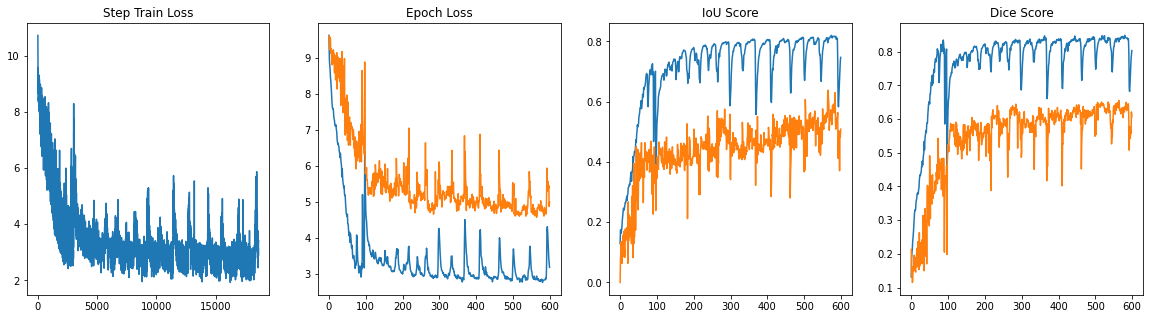

In [28]:
fig, axes = plt.subplots(1,4, figsize=(20,5))
axes[0].title.set_text('Step Train Loss')
axes[0].plot(step_losses)
axes[1].title.set_text('Epoch Loss')
axes[1].plot(epoch_losses)
axes[1].plot(val_epoch_losses)
axes[2].title.set_text('IoU Score')
axes[2].plot(epoch_iou_scores)
axes[2].plot(val_epoch_iou_scores)
axes[3].title.set_text('Dice Score')
axes[3].plot(epoch_dice_scores)
axes[3].plot(val_epoch_dice_scores)

In [29]:
root_path = ""
model_name = "UNet_withopel_5doors_grayscale_diceLoss_strongL2reg_8batch_noValSet.pth"

In [30]:
torch.save(model.state_dict(), root_path + model_name)
# print(model.state_dict())

In [31]:
model_path = root_path + model_name
if model_type == 'UNet++':
    model_ = Unet_2D(n_channels=num_channels, n_classes=num_classes).to(device)
elif model_type == 'UNet':
    model_ = UNet(num_classes=num_classes, num_channels=num_channels).to(device)

model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

tensor(0.5809, device='cuda:0')


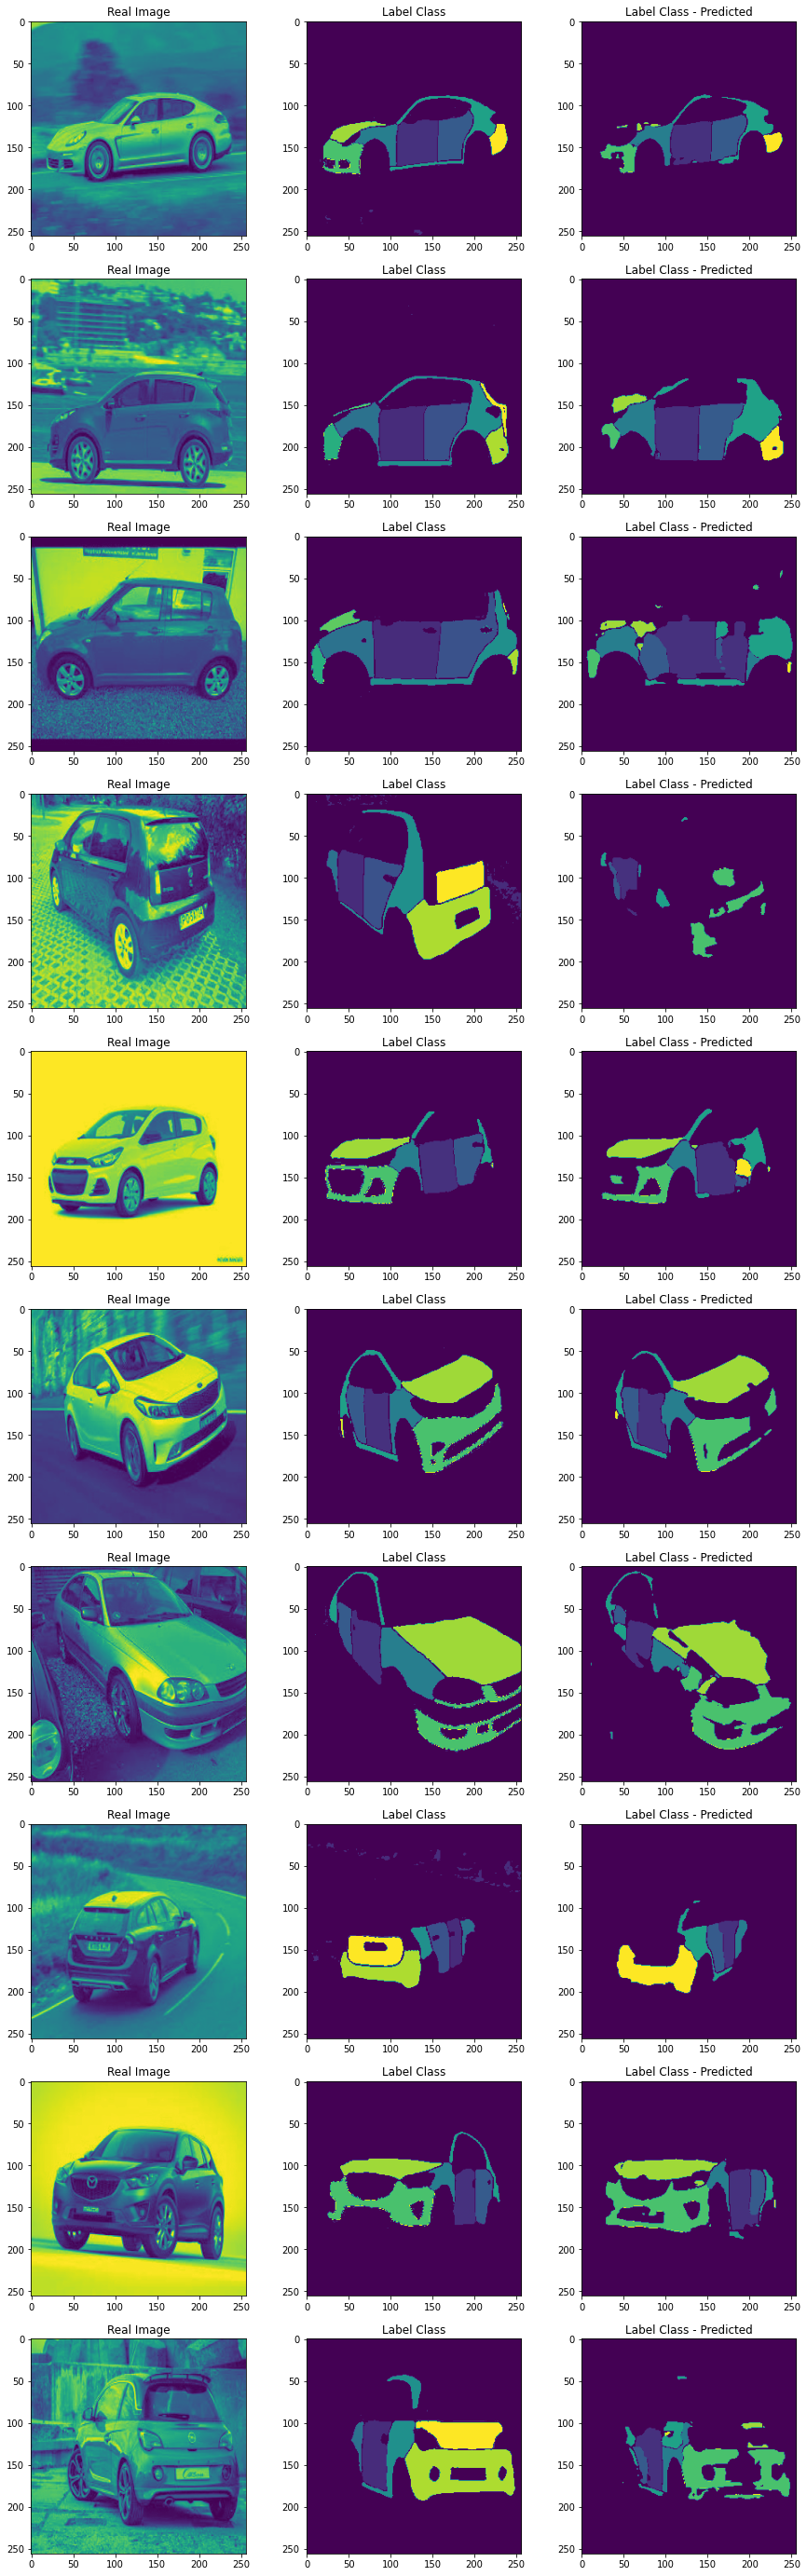

In [32]:
test_batch_size = 10
test_dataset = car_dataset(test_set, test_labels, transforms=trainTransform)
test_data_loader = DataLoader(test_dataset, batch_size=test_batch_size)

X,Y = next(iter(test_data_loader))
X,Y = X.to(device), Y.to(device)
if model_type == 'UNet++':
    Y_pred2, Y_pred1, Y_pred  = model_(X)
    # Y_pred = Y_pred + Y_pred1 + Y_pred2
elif model_type == 'UNet':
    Y_pred = model_(X)
# print(Y_pred.shape)
# Y_pred = torch.argmax(Y_pred, dim=1)
# print(Y_pred.shape)

inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []
dice_scores = []
dice_score = f1_score(num_classes=num_classes)

label_class_predicted = torch.argmax(Y_pred, dim=1)

for i in range(test_batch_size):
    
    landscape = X[i][0].cpu().detach().numpy()  # inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted1 = label_class_predicted[i].cpu().detach().numpy()
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted1)
    union = np.logical_or(label_class, label_class_predicted1)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)



    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Real Image")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted1)
    axes[i, 2].set_title("Label Class - Predicted")
print(dice_score(Y_pred, Y))

In [33]:
print(sum(iou_scores) / len(iou_scores))

0.644256442268834


0.5821924533614582
tensor(0.6039, device='cuda:0')


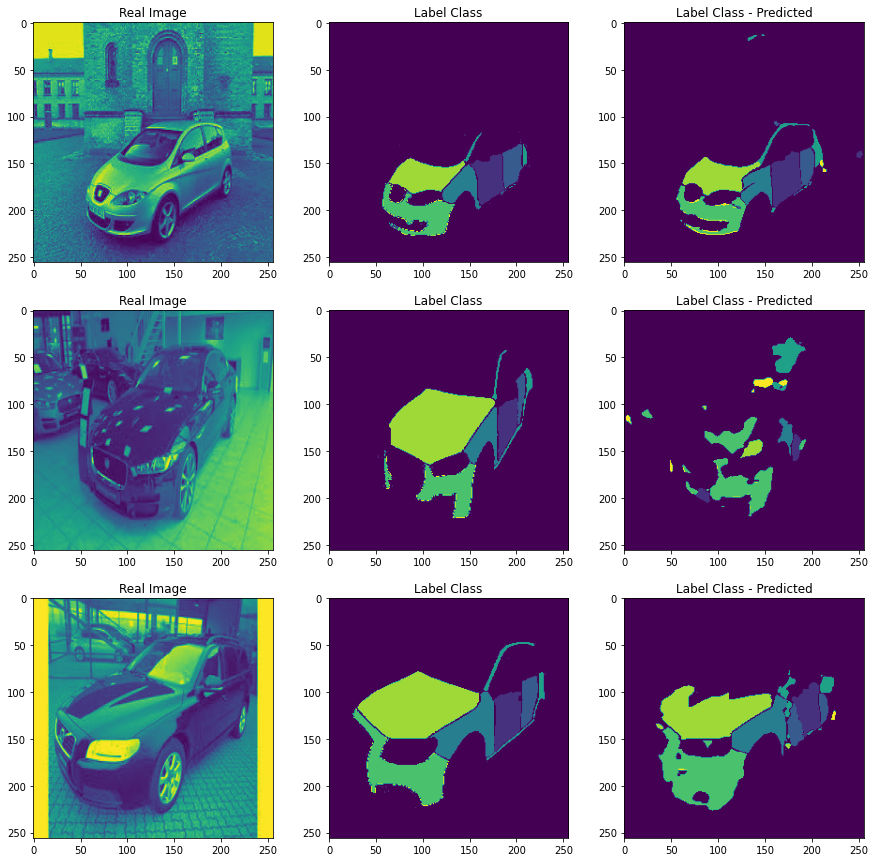

In [34]:
train_batch_size = 3
train_test_dataset = car_dataset(val_set, val_labels, transforms=trainTransform)
train_test_dataloader = DataLoader(train_test_dataset, batch_size=train_batch_size)

# Seeing how the model is doing on the train set, if it is overfitting or just underfitting
X,Y = next(iter(train_test_dataloader))
# print(test_set.shape)
# print(X.shape)
X,Y = X.to(device), Y.to(device)
# print(model_type)
if model_type == 'UNet++':
    _, _, Y_pred  = model_(X)
elif model_type == 'UNet':
    Y_pred = model_(X)
# print(Y_pred)
# print(Y_pred[0].shape)
# print(Y.shape)
label_class_predicted = torch.argmax(Y_pred, dim=1)

inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

fig, axes = plt.subplots(train_batch_size, 3, figsize=(3*5, train_batch_size*5))

iou_scores = []
f1scores = []

for i in range(train_batch_size):

    landscape = X[i][0].cpu().detach().numpy() # inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted1 = label_class_predicted[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted1)
    union = np.logical_or(label_class, label_class_predicted1)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)



    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Real Image")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted1)
    axes[i, 2].set_title("Label Class - Predicted")

print(sum(iou_scores) / len(iou_scores))
# dice
f1score = dice_score(Y_pred, Y)
print(f1score)